In [1]:
## Options
import pandas as pd
#from PI_client import pi_client
#pi = pi_client()
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

%load_ext autoreload
%autoreload 2

In [2]:
## Imports

## Mac imports
import sys
toolPath = r'/Users/decolvin/Box Sync/UCD_ECO_coding/mypy'
sys.path.append(toolPath)

## Main Imports
import mnv12 as mnv
print(mnv.version)
import matplotlib.pyplot as plt
print("Success!")

/Users/decolvin/anaconda/envs/MnV_Stuff/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Version 1.2
Success!


## Data Loading

### Local Data

In [68]:
# filePath = 'data/OATtest.xlsx'
filePath = r'/Users/decolvin/Downloads/GBSF Data 061318.csv'
#data = pd.read_excel(filePath, header=0, index_col=0, parse_dates=True)
data = pd.read_csv(filePath, header=0, index_col=0, parse_dates=True)
print(data.columns)

Index([u'chw', u'steam', u'ele', u'OAT'], dtype='object')


### PI Data

In [6]:
#tags = pi.search_by_point('*shields*kbtu*')[0]
#tags += pi.search_by_point('*shields*kbtu*')[0]

#print(tags)

#### Pull data

In [7]:
startDate = '2016-01-01'
endDate = '2017-01-01'
interval = '1 hour' #Can be "minute" "hour" "day"
calculation = 'calculated' # Redundant?

# data = pi.get_stream_by_point(tags, start=startDate, end=endDate, interval=interval, calculation=calculation)

# Data Section

In [62]:
data.head()

,chw,steam,ele,OAT
DateTime,,,,
2014-01-01 00:00:00,NaN,NaN,763.784922,43.601352
2014-01-01 01:00:00,NaN,NaN,774.602466,43.697068
2014-01-01 02:00:00,NaN,NaN,770.825713,42.367405
2014-01-01 03:00:00,NaN,NaN,777.338390,41.332300
2014-01-01 04:00:00,NaN,NaN,774.980198,40.331405


Q(75%): 357.91 Q(25%): 70.25
IQR value is 287.66
Ceiling adjusted by IQR - Now 1220.89


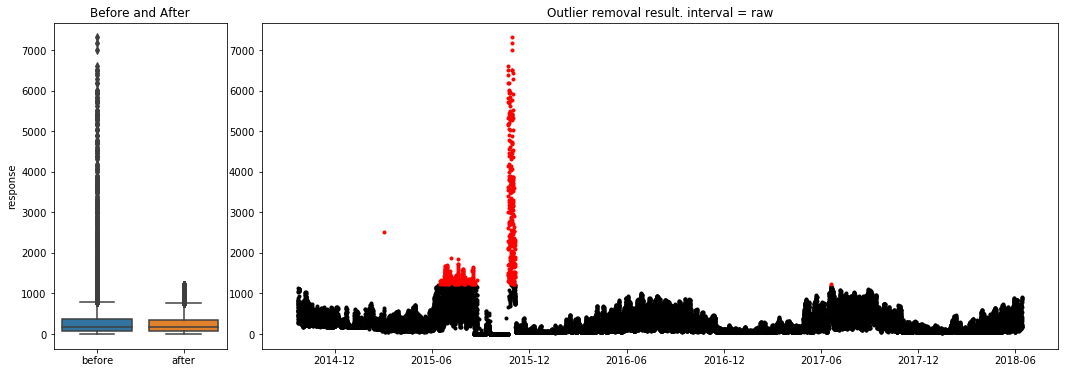

Deprecation warning: this function should be called calculate_degree_hours(). Use that name instead
OAT being loaded from master file


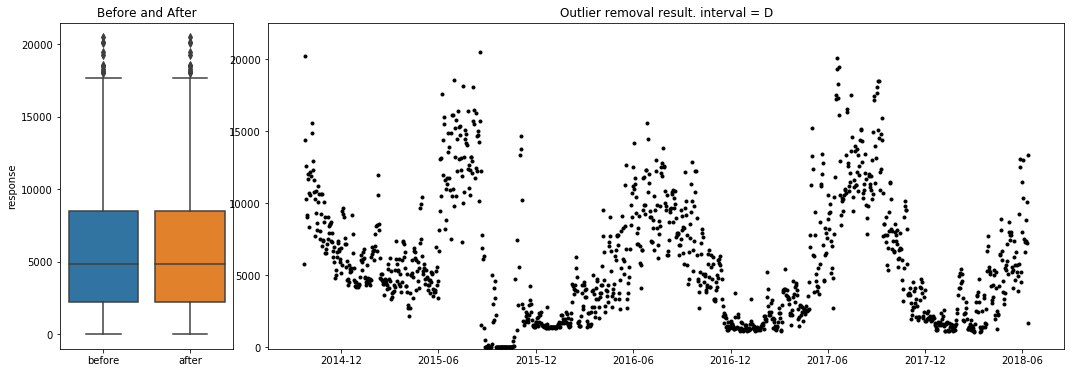

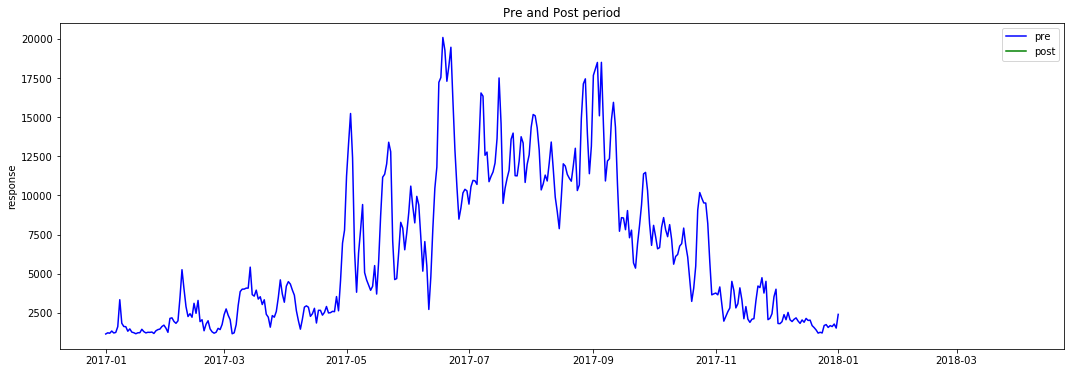

In [69]:
data.rename(columns={data.columns[0]:"response"},inplace=True)

inputDict = {'IQRmult' : 3.0,
             'IQR' : 'y', 
             'resampleRate' : 'D', #'D' for daily 'H' for hourly
             'verbosity' : 3,
             'sliceType' : 'ranges', #half, middate, ranges
             'midDate' : '2017-01-01', #only needed with sliceType : 'middate'
             'dateRanges' : ['2017-01-01','2018-01-01','2018-04-01','2018-04-01'], #only needed with sliceType : 'ranges'
             'OATsource' : 'file', #'self' or 'file'
             'OATname' : 'OAT', #Name of OAT column if OATsource is 'self'} #only needed with sliceType : 'ranges'
            }

dc = mnv.data_handler(data['response'], inputDict)
dc.default_clean()

## Run the next line incase the y-range is FUBAR
dc._outlier_plot(dc.modifiedData[dc.com], yrange=(-100,dc.modifiedData[dc.com].max()*1.1)) 

# plot 3
dc._pre_post_plot()

## Correlations

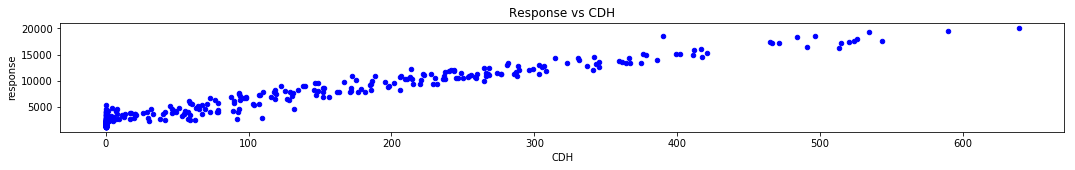

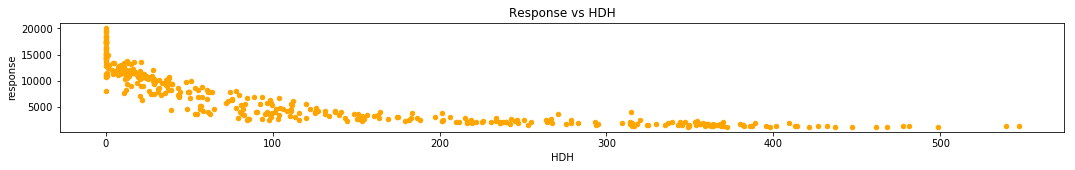

Response vs CDH = 0.98
Response vs HDH = -0.79
Response vs CDH2 = 0.87
Response vs HDH2 = -0.62


In [70]:
dc.pre.plot.scatter(x='CDH', y='response',figsize=(18,2), color='blue', title="Response vs CDH")
dc.pre.plot.scatter(x='HDH', y='response',figsize=(18,2), color='orange', title="Response vs HDH")
plt.show()
print "Response vs CDH = %.2f" %dc.pre.response.corr(dc.pre.CDH)
print "Response vs HDH = %.2f" %dc.pre.response.corr(dc.pre.HDH)
print "Response vs CDH2 = %.2f" %dc.pre.response.corr(dc.pre.CDH2)
print "Response vs HDH2 = %.2f" %dc.pre.response.corr(dc.pre.HDH2)

In [71]:
dc.pre.columns

Index([u'response', u'HDH', u'CDH', u'HDH2', u'CDH2', u'year', u'month', u'dayofmonth', u'hour', u'minute', u'dayofweek', u'daytime', u'weekday', u'saturday', u'sunday'], dtype='object')

# Many Linear Models

        AIC       AR2        R2     cvrmse postDiff                              params                                            summary
27  4587.32  0.984542  0.985285  0.0949735 -985.197   CDH + HDH + C(month) + C(weekday)                              OLS Regression Res...
11  4597.75  0.983927  0.984645  0.0968426 -807.973                CDH + HDH + C(month)                              OLS Regression Res...
12  4619.29  0.982753  0.983583   0.100317 -906.907  CDH + HDH2 + C(month) + C(weekday)                              OLS Regression Res...


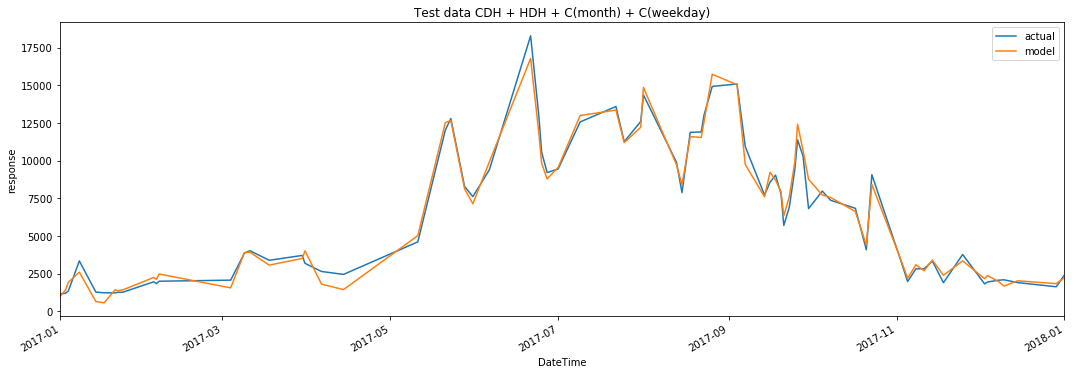

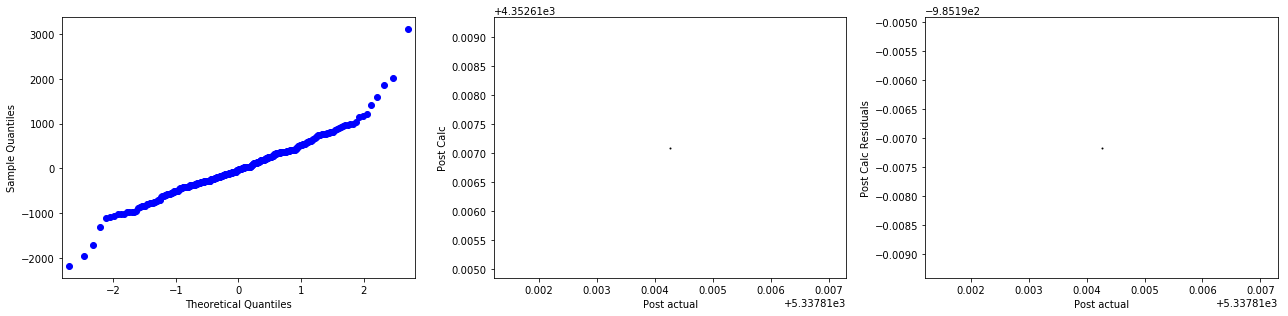

In [72]:
modelDict = {'params': 'CDH + HDH + C(month) + C(weekday)',
             'testTrainSplit': 'random',
             'randomState': 421990,
             'testSize': 0.2,
             'commodityRate': 0.056,
             'paramList': ['','C(month)','C(weekday)']}

allmod = mnv.many_ols(dc.pre, dc.post, modelDict)

allmod.run_all_linear()
print(allmod.statsPool[0:3])
allmod.plot_pool(1)
modelDict['params'] = allmod.statsPool.iloc[0]['params']

# Single Linear Model

/Users/decolvin/anaconda/envs/MnV_Stuff/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=17622.0, right=17622.0
  'left=%s, right=%s') % (left, right))


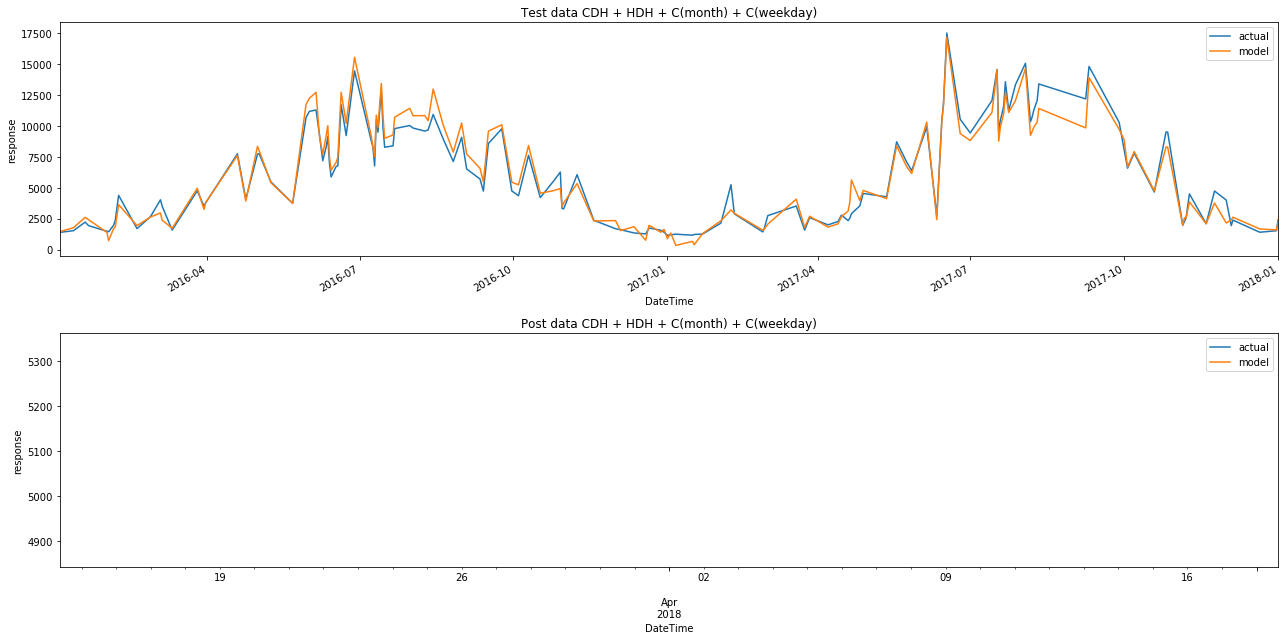

                  VIF
const       74.945138
HDH          5.335147
CDH          3.616808
dayofmonth   1.008643
dayofweek    2.789969
month_2      2.057886
month_3      2.574355
month_4      2.972995
month_5      3.668202
month_6      3.692586
month_7      3.938060
month_8      4.077880
month_9      4.060407
month_10     3.172629
month_11     2.321369
month_12     1.789530
weekday_1    2.800196


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1359.
Date:                Mon, 25 Jun 2018   Prob (F-statistic):               0.00
Time:                        08:46:25   Log-Likelihood:                -4684.9
No. Observations:                 585   AIC:                             9400.
Df Residuals:                     570   BIC:                             9465.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3691.3451    214.426     17.215      0.000    3270.184    4112.506
C(month)[T.2]    -116.8946    163.991     -0.713      0.476    -438.994     205.205
C(month)[T.3]    -505.1823    171.741     -2.942      0.003    -842.505    -167.860
C(month)[T.4]    -708.5641    187.819     -3.773      0.000   -1077.466    -339.663
C(month)[T.5]    -409.8289    203.277     -2.016      0.044    -809.092     -10.566
C(month)[T.6]    -288.2465    229.226     -1.257      0.209    -738.478     161.985
C(month)[T.7]    -407.8618    234.182     -1.742      0.082    -867.827      52.104
C(month)[T.8]      88.2536    222.048      0.397      0.691    -347.878     524.385
C(month)[T.9]     276.3938    217.607      1.270      0.205    -151.017     703.804
C(month)[T.10]    665.0140    195.880      3.395      0.001     280.280    1049.748
C(month)[T.11]    360.3206    163.084      2.209      0.028      40.002     680.639
C(month)[T.12]    260.0413    147.094      1.768      0.078     -28.870     548.953
C(weekday)[T.1]   299.2585     67.473      4.435      0.000     166.731     431.786
CDH                26.3231      0.428     61.525      0.000      25.483      27.163
HDH                -6.6791      0.524    -12.758      0.000      -7.707      -5.651
==============================================================================
Omnibus:                       26.568   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.171
Skew:                           0.190   Prob(JB):                     1.92e-14
Kurtosis:                       4.564   Cond. No.                     3.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
mod = mnv.ols_model(dc.pre, dc.post, modelDict)
mod.model_plot()


plt.show() # Show plot before Stats summary
print(mod.vif)
mod.Fit.summary()

### Savings

Savings = $-149432.54


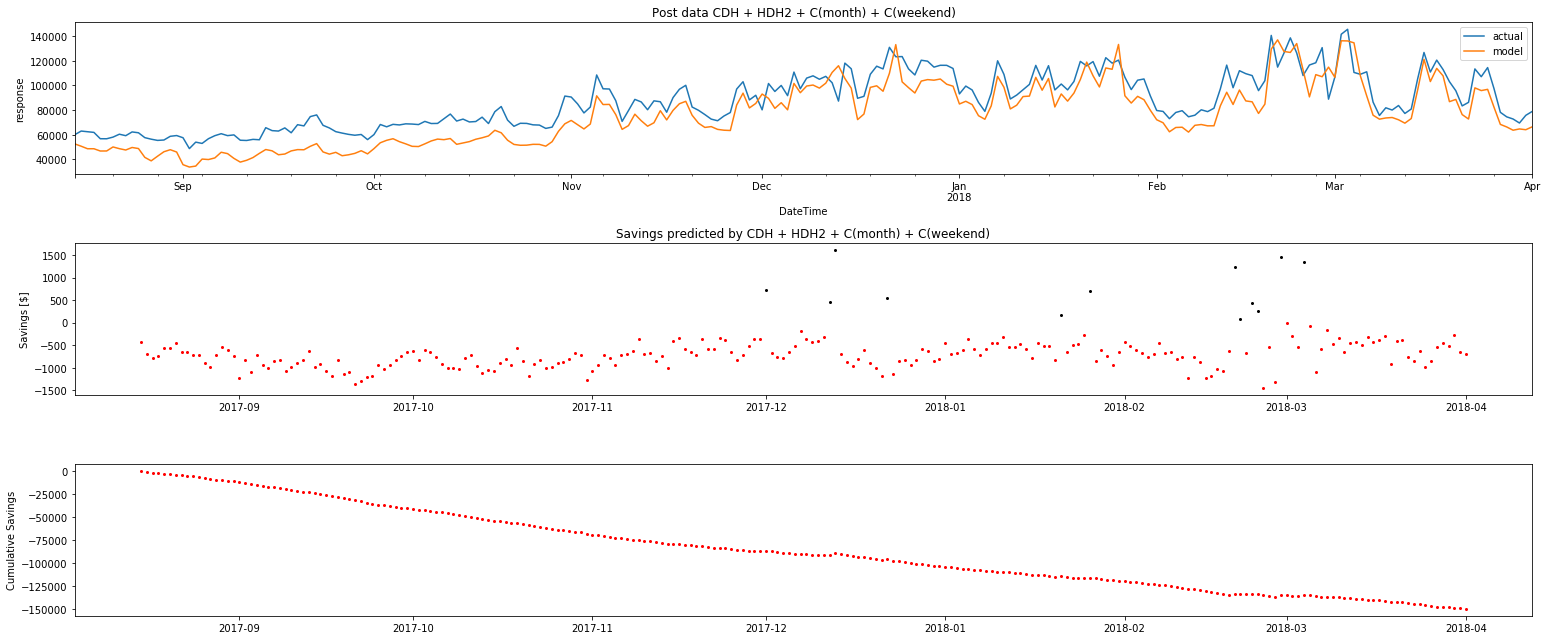

In [70]:
#rates = {'chw':0.056, 'steam':0.0157, 'elec':0.030} #kBTU prices for 2016(?)
#commodity = 'chw'

print("Savings = $" +str(round(mod.postCumsum * mod.params.commodityRate,2)))
mod.savings_plot(yaxis='dollars')